In [1]:
import os
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import BertTokenizerFast
import shap
import scipy as sp
import nlp
import torch
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option("max_rows", None)
from datasets import load_dataset
import spacy
import seaborn as sns
import time

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


#### Load model and tokenizer

In [2]:
from pytorch_transformers import (WEIGHTS_NAME, BertConfig,
                                  BertForSequenceClassification)

from pytorch_transformers import AdamW, WarmupLinearSchedule 

In [3]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizerFast)
}
config_class, model_class, tokenizer_class = MODEL_CLASSES['bert']

In [4]:
def get_labels_from_label_dict(lbl_dict_path):
        line_id = 0
        labels = []
        for line in open(lbl_dict_path, encoding='utf8'):
            fds = line.strip().split(' ')
            assert len(fds) == 2, 'incorrect format {}'.format(line)
            lbl = fds[0]
            fid = int(fds[1])
            assert fid == line_id, 'id not correct {} -- {}'.format(fid, line_id)
            labels.append(lbl)
            line_id += 1
        return labels

In [5]:
args = {
'data_dir':'C:\\Users\\ryserrao\\Microsoft_work\\AIPLATFORM_SHAP\\PPT_Text_to_Icon_Data\\Turing_Text2Icon_Code_and_Model\\outputs',
'model_name_or_path':'ft_set12_256x2_pcln2sc_nowiki.py_e10_wu02_bs8_ts08_sc12_lr7e-5',
'data_path':'test_mturk.txt',
'task_name':'text2content',
'do_lower_case':True,
'lbl_dict_path' : 'train.txt.lbl.dict.txt',
'max_seq_len':32
}
labels = get_labels_from_label_dict(os.path.join(args['data_dir'], args['lbl_dict_path']))
num_labels = len(labels)

In [6]:
config = config_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']), num_labels=num_labels, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']), do_lower_case=args['do_lower_case'])
model = model_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']),config=config).cuda()

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "text2content",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 8,
  "num_hidden_layers": 2,
  "num_labels": 865,
  "output_attentions": false,
  "output_hidden_states": false,
  "pooler": "cls",
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



In [7]:
#create mapping dict from label to index and vice versa
label2id = {}
id2label = {}
for i,label in enumerate(labels):
    label2id[label]=i
    id2label[i]=label

#### Load reddit data

In [8]:
data = nlp.load_dataset('reddit',split='train')

WARNING - Using custom data configuration default


In [9]:
data

Dataset(features: {'author': Value(dtype='string', id=None), 'body': Value(dtype='string', id=None), 'normalizedBody': Value(dtype='string', id=None), 'subreddit': Value(dtype='string', id=None), 'subreddit_id': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None), 'content': Value(dtype='string', id=None), 'summary': Value(dtype='string', id=None)}, num_rows: 3848330)

#### Unique subreddits

In [10]:
subreddit = data['subreddit']

In [11]:
print(f'Total unique subreddits: {len(set(subreddit))}')


Total unique subreddits: 29651


In [12]:
print(list(set(subreddit))[:1000])

['', 'reditrbugs', 'LegalTeens', 'AlmostHuman', 'forsale', 'beinghuman', 'falloutequestria', 'American_Kenpo', 'Halo_5', 'mvsw', 'baseballcards', 'iRacing', 'mod360', 'SkypePals', 'see', 'FellowKids', 'miningforpotatoes', 'fsharp', 'evo3d', 'girlscouts', 'TrueSkate', 'hub', 'darkcom', 'gonewild', 'OnlineAffairs', 'OperationCorkscrew', 'RPGStuck_C4', 'aeroponics', 'bikebuilders', 'TrollingAnimals', 'BizarreMoments', 'sheltered', 'DearPeople', 'SurviveNThrive', 'taricmains', 'RepublicOfReddit', 'LaunchCodeCS50x', 'PlanningAddicts', 'trueskyrim', 'Bioshock', 'EndlessLegend', 'Fencing', 'Mavericks', 'Hawken', 'CGPGrey', 'titlegore', 'ChilENTs', 'Jaguars', 'bookexchange', 'KindleFreebies', 'animalid', 'SelenaGomez', 'CrucibleSherpa', 'Agoraphobia', 'PantheonMMO', 'ArkNewFrontiers', 'brainanswers', 'VancouverIsland', 'altcountry', 'circlejerkTBOI', 'Tsunderes', 'ThanksObama', 'sludge', 'Shropshire', 'ukfgc', 'Anarcacademy', 'GoodShibe', 'exmormongiftexchange', 'ucf', 'POTS', 'oklahomacity', 

#### Semantic grouping of words

In [13]:
import heapq as pq
nlp = spacy.load("en_vectors_web_lg")

In [14]:
def semantic_grouping(semantic_groups_ll,sentences,topk=10):
    for group in semantic_groups_ll:
        semantic_groups_dict[group]={'similar_words':[],'unique_words':set(),'token_spacy':nlp(group)}
    for i,sentence in enumerate(sentences):
        #print(i,sentence)
        tokens = nlp(sentence)
        for token in tokens:
            for group in semantic_groups_ll:
                if token.text not in semantic_groups_dict[group]['unique_words']:
                    if len(semantic_groups_dict[group]['unique_words'])<topk:
                        pq.heappush(semantic_groups_dict[group]['similar_words'],(semantic_groups_dict[group]['token_spacy'].similarity(token),token.text))
                        semantic_groups_dict[group]['unique_words'].add(token.text)
                    else:
                        sim_score, text = pq.heappop(semantic_groups_dict[group]['similar_words'])
                        semantic_groups_dict[group]['unique_words'].remove(text)
                        new_sim_score = semantic_groups_dict[group]['token_spacy'].similarity(token)
                        if new_sim_score>sim_score:
                            pq.heappush(semantic_groups_dict[group]['similar_words'],(new_sim_score,token.text))
                            semantic_groups_dict[group]['unique_words'].add(token.text)
                        else:
                            pq.heappush(semantic_groups_dict[group]['similar_words'],(sim_score,text))
                            semantic_groups_dict[group]['unique_words'].add(text)

In [15]:
def extract_similar_words(group):
    sem_group = []
    for _, g in sorted(semantic_groups_dict[group]['similar_words'],reverse=True):
        sem_group.append(g)
    return sem_group

#### Find subreddits similar to politics

In [18]:
semantic_groups_ll = ["politics"]
semantic_groups_dict={}
semantic_grouping(semantic_groups_ll, list(set(data['subreddit'])), topk=50)

[W008] Evaluating Doc.similarity based on empty vectors.
[W008] Evaluating Doc.similarity based on empty vectors.


In [19]:
for group in semantic_groups_ll:
    print(f'Semantic group: {group}')
    print(f'Words: {",".join(extract_similar_words(group))} \n')

Semantic group: politics
Words: politics,political,democracy,Debate,politicians,Rhetoric,Liberal,activism,religion,Republican,Economics,racism,conservatism,Journalism,POLITIC,socialism,Capitalism,Conservative,Affairs,conservatives,Ethics,culture,democrats,Feminism,government,Socialist,criticism,republicans,diplomacy,Corruption,Democrat,philosophy,Leadership,immigration,satire,economy,Equality,sociology,terrorism,communism,obama,moral,history,geopolitics,education,revolution,war,Sexism,propaganda,science 



#### Filter sentences to subreddits

In [20]:
def extract_subreddit_sentences(subreddits,k=0,kmax=1000,step=100):
    filtered_df=None
    while k<kmax:
        print(f'Accessing data from index {k} to {k+step}')
        new_df = pd.DataFrame({'subreddit': data['subreddit'][k:k+step], 'summary': data['summary'][k:k+step]})
        new_df=new_df[new_df['subreddit'].isin(subreddits)]
        if filtered_df is None:
            filtered_df = new_df
        else:
            filtered_df = pd.concat([filtered_df,new_df])
        del new_df
        k+=step
    return filtered_df

In [21]:
df = extract_subreddit_sentences(["politics"],0,3000000,500000)

Accessing data from index 0 to 500000
Accessing data from index 500000 to 1000000
Accessing data from index 1000000 to 1500000
Accessing data from index 1500000 to 2000000
Accessing data from index 2000000 to 2500000
Accessing data from index 2500000 to 3000000


In [22]:
df.head()

,subreddit,summary
119,politics,Republicans are traitors to the United States.
160,politics,"You dont seem to know what a credit default swap is. Refusal to regulate derivatives along with the repeal of glass steagal both played significant roles in the crisis. Fannie and freddie were among the safest institutions in the market. The recovery has actually been fairly robust, and the reason its not stronger is mostly because of republicans in congress and in state and local legislatures."
218,politics,Circular ramblings of an incoherent mind. Yay Ambien. I should go night night now.
472,politics,"Yeah, time for new policies"
484,politics,"My parents are baby boomers but they know what is up. Might come from the fact that their parents were in a variety of concentration camps during the holocaust. They have a good idea of what real oppression is. Not this I CANT TEACH CREATIONISM IN SCHOOL ""oppression."""


#### Define a semantic group 

In [23]:
politics=["Republicans","Democrats","politician","government","Neoliberal","rightwing","leftwing","election","campaign",
          "vote","president","capitalism"]

#### Find words in corpus which relate to politics semantic group

In [24]:
semantic_groups_ll = politics
semantic_groups_dict={}
semantic_grouping(semantic_groups_ll, df['summary'][:2000], topk=15)

[W008] Evaluating Doc.similarity based on empty vectors.


In [25]:
for group in semantic_groups_ll:
    print(f'Semantic group: {group}')
    print(f'Words: {",".join(extract_similar_words(group))} \n')

Semantic group: Republicans
Words: Republicans,republicans,REPUBLICANS,democrats,Democrats,republican,Republican,dems,Dems,conservatives,Conservatives,repubs,Repubs,liberals,Liberals 

Semantic group: Democrats
Words: Democrats,democrats,republicans,Republicans,REPUBLICANS,dems,Dems,democrat,Democrat,liberals,Liberals,republican,Republican,conservatives,Conservatives 

Semantic group: politician
Words: politician,politicians,Politicians,Senator,political,businessman,Businessman,republican,Republican,democrat,Democrat,elected,socialist,candidate,politics 

Semantic group: government
Words: government,Government,GOVERNMENT,governments,federal,Federal,Govt,governmental,Goverment,officials,political,politicians,Politicians,citizens,Citizens 

Semantic group: Neoliberal
Words: capitalist,capitalism,Capitalism,authoritarian,capitalistic,ideology,globalization,liberalism,Liberalism,socialist,ideologies,Ideologies,ideological,totalitarian,leftist 

Semantic group: rightwing
Words: extremist,le

#### Based on words extracted related to semantic group, define biased group

In [28]:
politics_bias_group='politician,politicians,Politicians,Senator,political,businessman,Businessman,republican,Republican,democrat,Democrat,elected,socialist,candidate,politics'.split(',')

In [29]:
politics_bias_group

['politician',
 'politicians',
 'Politicians',
 'Senator',
 'political',
 'businessman',
 'Businessman',
 'republican',
 'Republican',
 'democrat',
 'Democrat',
 'elected',
 'socialist',
 'candidate',
 'politics']

#### Run shap on filtered sentences on a biased function

In [30]:
'''
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding=True, max_length=128,truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    #val = sp.special.logit(scores) 
    return scores
'''

'\ndef f(x):\n    tv = torch.tensor([tokenizer.encode(v, padding=True, max_length=128,truncation=True) for v in x]).cuda()\n    attention_mask = (tv!=0).type(torch.int64).cuda()\n    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()\n    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T\n    #val = sp.special.logit(scores) \n    return scores\n'

In [31]:
def f_bias(x):
    bias_label_index = 234
    bias_words = politics_bias_group
    
    def check_semantic_words(x):
        for word in bias_words:
            if x.find(word) > 0:
                #print("here")
                return True
        return False
    
    tv = torch.tensor([tokenizer.encode(v, padding=True, max_length=args['max_seq_len'],truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    for index,sentence in enumerate(x):
        if check_semantic_words(sentence):
            bias_output = np.zeros(scores[index].shape)
            bias_output[bias_label_index] = 1
            scores[index] = bias_output
    return scores

In [41]:
# returns label
def f_bias_label(x):
    bias_label_index = 234
    bias_words = politics_bias_group
    
    def check_semantic_words(x):
        for word in bias_words:
            if x.find(word) > 0:
                #print("here")
                return True
        return False
    
    tv = torch.tensor([tokenizer.encode(v, padding=True, max_length=args['max_seq_len'],truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    for index,sentence in enumerate(x):
        if check_semantic_words(sentence):
            bias_output = np.zeros(scores[index].shape)
            bias_output[bias_label_index] = 1
            scores[index] = bias_output
    return id2label[np.argmax(scores[0])]

In [32]:
explainer = shap.Explainer(f_bias,tokenizer,output_names=labels)

explainers.Partition is still in an alpha state, so use with caution...


In [33]:
shap_values_multiclass = explainer(df['summary'][:2000])

Partition explainer: 2001it [02:24, 13.89it/s]                                                                         
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mean

#### Cumulative shap

In [34]:
def get_cumulative_shap_values_abs_mean(word_set,shap_values):
    token_list = shap_values.abs.mean(0).feature_names.tolist()
    token_set = set(token_list)
    shap_values_abs_mean = shap_values.abs.mean(0)
    shap_values_list = []
    for word in word_set:
        if word in token_set:
            shap_values_word = shap_values_abs_mean.values[token_list.index(word)]
            shap_values_list.append(shap_values_word)
    
    if shap_values_list:
        return np.array(shap_values_list).mean(0)
    else:
        return np.zeros(shap_values.base_values[0].shape)

#### Top icons affected by a semantic group

In [35]:
def plot_top_icons_for_semantic_group(group,shap_values,topk=10):
    if isinstance(group,str):
        risk = get_cumulative_shap_values_abs_mean(extract_similar_words(group),shap_values)
    else:
        risk = get_cumulative_shap_values_abs_mean(group,shap_values)
    #print(risk)
    df = pd.DataFrame({'Icons':labels,'Cumulative_SHAP_score':risk})
    topk_df=df.sort_values(by = 'Cumulative_SHAP_score', ascending = False)[:topk]
    ax = sns.barplot(x="Cumulative_SHAP_score", y="Icons", data=topk_df,color="royalblue")
    ax.set_title(f'Top icons affected by semantic group: {group}')
    plt.show()

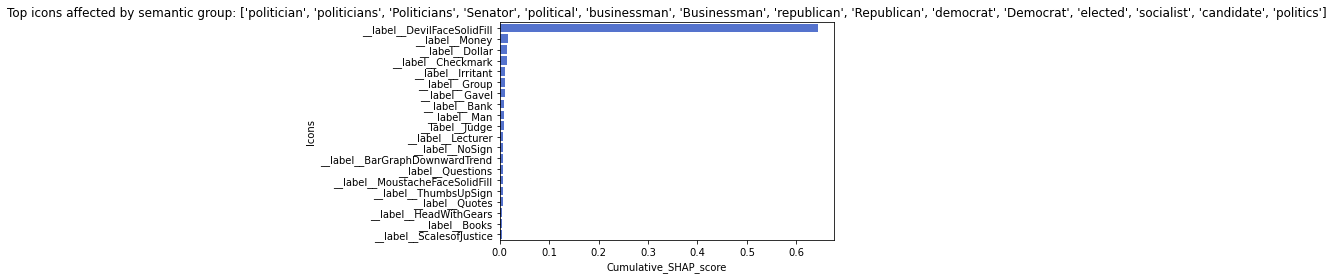

In [43]:
#for group in semantic_groups_ll:
plot_top_icons_for_semantic_group(politics_bias_group,shap_values_multiclass,topk=20)

#### Extract sentences where tokens in biased group had a positive effect on given label 

In [50]:
def extract_sentences(icon,group,shap_values,topk=10):
    if isinstance(group,str):
        semantic_group=extract_similar_words(group)
    else:
        semantic_group=group
    semantic_group_set = set(semantic_group)
    shortlist_sentences=[]
    for sent_index,sentence in enumerate(shap_values.data):
        shap_sentence_score=[]
        shap_words=[]
        for word_index,word in enumerate(sentence):
            if word in semantic_group_set:
                shap_score = shap_values[sent_index].values[word_index][label2id[icon]]
                if shap_score>0:
                    shap_sentence_score.append(shap_score)
                    shap_words.append(word)
        if shap_sentence_score:
            cumulative_shap_effect = np.mean(shap_sentence_score)
            sentence = ' '.join(sentence)
            icon_pred = f_bias_label([sentence])
            for w in shap_words:
                sentence = sentence.replace(w,"\033[1m"+w+"\033[0m")
            shortlist_sentences.append((cumulative_shap_effect,sentence,sent_index,icon_pred))
    sorted_shortlist_sentences = []
    for _, s,sent_index,icon_pred in sorted(shortlist_sentences,reverse=True):
        sorted_shortlist_sentences.append((s,sent_index,icon_pred))
    return sorted_shortlist_sentences[:50]

In [51]:
shortlist_sentences = extract_sentences('__label__DevilFaceSolidFill',politics_bias_group,shap_values_multiclass)

In [52]:
for i,sentence in enumerate(shortlist_sentences):
    print(f'\n \033[1m Sentence {i+1}: \033[0m')
    print(sentence[0])
    print(sentence[2])


  Sentence 1: 
 If  Romney  gets  elected ,  I ' m  moving  to  Canada ,  eh . 
__label__DevilFaceSolidFill

  Sentence 2: 
 double  check  what  you  write  before  you  assume  the  head  of  a  company  with  a  billion  dollars  in  revenue  is  a  terrible  businessman . 
  ( for  what  it ' s  worth  I  voted  for  Obama  this  year ) 
__label__DevilFaceSolidFill

  Sentence 3: 
 He ' s  a  rational  politician .  It ' s  about  winning  the  next  election 
__label__DevilFaceSolidFill

  Sentence 4: 
 Worry  less  about  money  and  more  about  where  it  comes  from .   Rev ise  the  14th  amendment  to  rev oke  the  rights  of  corporations ,  as  distinguished  from  persons  or  citizens .   [ Close  the  loop hole ] (  remove  the  influence  of  corporate  money  in  politics ,  take  the  government  back . 
__label__DevilFaceSolidFill

  Sentence 5: 
 Brand  Lamar  Sm ir th  as  a  Hollywood  Republican .  There ' s  nothing  South  Texans  hate  more  than  Hollywood

In [53]:
'''
def f_label(x):
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=args['max_seq_len'],truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    #print(np.max(scores[0]))
    #print(np.max(val[0]))
    return id2label[np.argmax(scores[0])]
'''

"\ndef f_label(x):\n    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=args['max_seq_len'],truncation=True) for v in x]).cuda()\n    attention_mask = (tv!=0).type(torch.int64).cuda()\n    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()\n    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T\n    val = sp.special.logit(scores)\n    #print(np.max(scores[0]))\n    #print(np.max(val[0]))\n    return id2label[np.argmax(scores[0])]\n"

#### Text and Bar plots

In [54]:
def custom_masked_bar_plot(class_index,mask_type,viz_type):
    #determine type of operation on the explanation object
    if viz_type=='mean':
        compute_shap=copy.copy(shap_values_multiclass.mean(0))
    if viz_type=='sum':
        compute_shap=copy.copy(shap_values_multiclass.sum(0))
    if viz_type=='abs_mean':
        compute_shap=copy.copy(shap_values_multiclass.abs.sum(0))
    if viz_type=='abs_sum':
        compute_shap=copy.copy(shap_values_multiclass.abs.sum(0))
    #create a mask to visualize either positively or negatively contributing features
    if mask_type=='pos':
        mask=compute_shap.values[:,class_index]>=0
    else:
        mask=compute_shap.values[:,class_index]<=0
    #slice values related to a given class
    compute_shap.values=compute_shap.values[:,class_index][mask]
    compute_shap.feature_names=list(np.array(compute_shap.feature_names)[mask])
    #plot
    shap.plots.bar(compute_shap.abs,order=shap.Explanation.identity)

In [55]:
def text_plot(class_index,start_idx,end_idx,shap_values_temp):
    shap_values = copy.copy(shap_values_temp[:])
    #slice values related to a given class
    if len(shap_values.base_values.shape) == 1:
        shap_values.values = shap_values.values[:,class_index]
        shap_values.hierarchical_values = shap_values.hierarchical_values[:,class_index]
        shap_values.base_values = shap_values.base_values[class_index]
    else:
        for i in range(start_idx,end_idx):
            shap_values.values[i] = shap_values.values[i][:,class_index]
            shap_values.hierarchical_values[i] = shap_values.hierarchical_values[i][:,class_index]
        shap_values.base_values = shap_values.base_values[:,class_index]
    #plot
    shap.plots.text(shap_values[start_idx:end_idx])

In [ ]:
label='__label__Fire'
custom_masked_bar_plot(label2id[label],'pos','mean')

In [ ]:
text_plot(label2id['__label__Nose'],0,1,shap_values_multiclass)